# Week 9: Dropout

In [1]:
# Load the dataset...
import torch
from pathlib import Path
from torch import nn
import sys
import numpy as np
from sklearn.datasets import fetch_openml
import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from torch import optim
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms

%matplotlib notebook

if("dataset" not in globals()):
    root_dir = Path().resolve()
    dataset = torchvision.datasets.MNIST(root_dir, download=True, transform=transforms.ToTensor())
    train, test = torch.utils.data.random_split(dataset, [int(len(dataset) * 0.8), int(len(dataset) * 0.2)])

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /home/anna/Documents/GitHub/Week_9_Dropout/MNIST/raw/train-images-idx3-ubyte.gz to /home/anna/Documents/GitHub/Week_9_Dropout/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /home/anna/Documents/GitHub/Week_9_Dropout/MNIST/raw/train-labels-idx1-ubyte.gz to /home/anna/Documents/GitHub/Week_9_Dropout/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /home/anna/Documents/GitHub/Week_9_Dropout/MNIST/raw/t10k-images-idx3-ubyte.gz to /home/anna/Documents/GitHub/Week_9_Dropout/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /home/anna/Documents/GitHub/Week_9_Dropout/MNIST/raw/t10k-labels-idx1-ubyte.gz to /home/anna/Documents/GitHub/Week_9_Dropout/MNIST/raw



First, load in MNIST and display a character:

Image Size: (1, 28, 28)


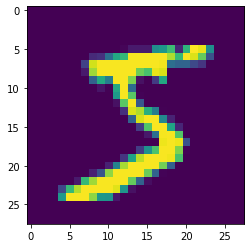

In [2]:
%matplotlib inline
print("Image Size:", tuple(dataset[0][0].shape))
plt.imshow(dataset[0][0].moveaxis(0, -1))

In [3]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda") # GPU
else:
    device = torch.device("cpu") # CPU
    
print(f"Running PyTorch Using: {device}")

Running PyTorch Using: cpu


In [4]:
batch_size = 100

to_device = lambda a: a.to(device)

test_loader = torch.utils.data.DataLoader(test, batch_size, shuffle=True)
train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle=True)

In [5]:
# Functions for training a model...
def train_model(
    model, 
    train_data, 
    test_data, 
    optimizer, 
    error_func, 
    n_epochs,
    device,
    print_every=100,
    print_accuracy=True
):
    for epoch_i in range(1, n_epochs + 1):
        model.train()
        for i, (img, label) in enumerate(train_data, 1):
            # Zero gradients...
            model.zero_grad()
            # Run model...
            predicted = model.forward(img.to(device))
            
            # Compute loss, backpropigate, and optimize the weights...
            loss = error_func(predicted, label.to(device))
            loss.backward()
            optimizer.step()
            
            if((i % print_every == 0) or (i == len(train_data))):
                print(f"Epoch: {epoch_i}/{n_epochs}, Iter: {i}/{len(train_data)}, Loss: {loss:.04f}")
                
        # Run against the test set and train set at the end of each epoch to get accuracy...
        if(print_accuracy):
            model.eval()
            acc1 = get_accuracy(model, train_data)
            print(f"Epoch {epoch_i} Train Accuracy: {acc1 * 100:.02f}%")
            acc2 = get_accuracy(model, test_data)
            print(f"Epoch {epoch_i} Test Accuracy: {acc2 * 100:.02f}%\n")
    
    return model
        
        
def get_accuracy(model, data):
        run = 0
        correct = 0
        
        for img, label in data:
            run += len(img)
            result = model.forward(img.to(device)).cpu().detach().numpy()
            correct += np.sum(np.argmax(result, axis=1) == label.cpu().detach().numpy())
        
        return correct / run

### Model Without Dropout

Our first model will be a regular MLP classifying MNIST digits without dropout. Recall that in this network, all neurons (or nodes) will be present for every training case.

In [6]:
class VanillaNN(nn.Module):
    def __init__(self, input_size: tuple, hidden_layer_sizes: list, class_count: int): 
        super().__init__()
        layers = [
            nn.Linear(np.prod(input_size), hidden_layer_sizes[0]),
            nn.LeakyReLU()
        ]
        
        for this_size, next_size in zip(hidden_layer_sizes[:-1], hidden_layer_sizes[1:]):
            layers.extend([
                nn.Linear(this_size, next_size),
                nn.LeakyReLU()
            ])
            
        layers.append(nn.Linear(hidden_layer_sizes[-1], class_count))
        
        self._linear_layers = nn.Sequential(*layers)
        self._softmax = nn.Softmax(-1)
        
    def linear_layer(self, index: int):
        return self._linear_layers[index * 2]
        
    def forward(self, x: torch.tensor, exec_depth: int = None) -> torch.tensor:
        if(exec_depth is None):
            return self._softmax(self._linear_layers(x.reshape(x.shape[0], -1)))
        else:
            # Return internal values exec_layers layers in...
            return self._linear_layers[:exec_depth * 2](x.reshape(x.shape[0], -1))

In [13]:
#TODO: Below, set the number of hidden units per layer and number of output classes
hidden_layers = [512, 1024] # this should be an array with units per hidden layer
num_classes = 10

vnn = VanillaNN(dataset[0][0].shape, hidden_layers, num_classes).to(device)
print(vnn)

VanillaNN(
  (_linear_layers): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=512, out_features=1024, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=1024, out_features=10, bias=True)
  )
  (_softmax): Softmax(dim=-1)
)


In [14]:
# TODO: Set epochs and learning rate. Be sure the network's performance has begun to plateau for a good comparison
n_epochs = 15
lr = 1e-4

# Set up everything...
optimizer = optim.Adam(vnn.parameters(), lr=lr)
loss_func = nn.CrossEntropyLoss()

In [15]:
vnn = train_model(vnn, train_loader, test_loader, optimizer, loss_func, n_epochs, device)

Epoch: 1/15, Iter: 100/480, Loss: 1.7689
Epoch: 1/15, Iter: 200/480, Loss: 1.5694
Epoch: 1/15, Iter: 300/480, Loss: 1.6395
Epoch: 1/15, Iter: 400/480, Loss: 1.6084
Epoch: 1/15, Iter: 480/480, Loss: 1.5696
Epoch 1 Train Accuracy: 90.79%
Epoch 1 Test Accuracy: 90.30%

Epoch: 2/15, Iter: 100/480, Loss: 1.5786
Epoch: 2/15, Iter: 200/480, Loss: 1.5435
Epoch: 2/15, Iter: 300/480, Loss: 1.5429
Epoch: 2/15, Iter: 400/480, Loss: 1.5527
Epoch: 2/15, Iter: 480/480, Loss: 1.5288
Epoch 2 Train Accuracy: 92.34%
Epoch 2 Test Accuracy: 91.73%

Epoch: 3/15, Iter: 100/480, Loss: 1.5268
Epoch: 3/15, Iter: 200/480, Loss: 1.5595
Epoch: 3/15, Iter: 300/480, Loss: 1.5492
Epoch: 3/15, Iter: 400/480, Loss: 1.5061
Epoch: 3/15, Iter: 480/480, Loss: 1.5618
Epoch 3 Train Accuracy: 93.32%
Epoch 3 Test Accuracy: 92.56%

Epoch: 4/15, Iter: 100/480, Loss: 1.5004
Epoch: 4/15, Iter: 200/480, Loss: 1.5722
Epoch: 4/15, Iter: 300/480, Loss: 1.5273
Epoch: 4/15, Iter: 400/480, Loss: 1.5350
Epoch: 4/15, Iter: 480/480, Loss: 1

In [16]:
print(f"Final Model Test Accuracy: {get_accuracy(vnn, test_loader) * 100:.02f}%")

Final Model Test Accuracy: 96.32%


### Model With Dropout

Now, let's try the same network with dropout. Dropout is simple: For every layer, the input to any given neuron is zeroed out with probability *p*. When a neuron's input is zeroed out, it's effectively removed from the model. Which neurons are dropped are determined by a vector of 1's and 0's generated by a Bernoulli distribution (at least, in the paper) for each training case.

Notably, dropout effectively turns a single model into an ensemble of models that share weights, where each model in the ensemble is a random subnetwork that only rarely gets trained.

**TODO: How many subnetworks are possible in a network with *n* units?**

*2^n possible subnetworks*

**TODO: How does dropout change the relationship of units in the network with their neighbors?**

*Each unit can no longer rely on the presence of all other units, so their functions must be more easily separated into individual units.*

In [18]:
class DropoutNN(nn.Module):
    def __init__(
        self, 
        input_size: tuple, 
        hidden_layer_sizes: list, 
        dropout_values: list, 
        class_count: int
    ):
        super().__init__()
        layers = [
            #TODO: Add dropout here (hint: there's a PyTorch function for it).
            #Which value from the dropout list should go here?
            nn.Dropout(p=dropout_values[0]),
            nn.Linear(np.prod(input_size), hidden_layer_sizes[0]),
            nn.LeakyReLU()
        ]
        
        for this_size, next_size, dv in zip(hidden_layer_sizes[:-1], hidden_layer_sizes[1:], dropout_values[1:]):
            layers.extend([
                #TODO: Add dropout here too
                nn.Dropout(p=dv),
                nn.Linear(this_size, next_size),
                nn.LeakyReLU()
            ])
            
        layers.extend([
            #TODO: Last dropout call here. Which value should it take?
            nn.Dropout(p=dropout_values[-1]),
            nn.Linear(hidden_layer_sizes[-1], class_count)
        ])
        
        self._linear_layers = nn.Sequential(*layers)
        self._softmax = nn.Softmax(-1)
        
    def linear_layer(self, index: int):
        return self._linear_layers[index * 3 + 1]
        
    def forward(self, x: torch.tensor, exec_depth: int = None) -> torch.tensor:
        if(exec_depth is None):
            return self._softmax(self._linear_layers(x.reshape(x.shape[0], -1)))
        else:
            # Return internal values exec_layers layers in...
            return self._linear_layers[:exec_depth * 3](x.reshape(x.shape[0], -1))

In [20]:
# TODO: Specify number of hidden units per layer, per-layer dropout probability (between 0 and 1), and number of 
# output classes. How many per-layer dropout probabilities does this model require?
hidden_layers = [512,1024]
dropout_probs = [0.5, 0.5, 0.5]
num_classes = 10

dnn = DropoutNN(dataset[0][0].shape, hidden_layers, dropout_probs, num_classes).to(device)
print(dnn)

DropoutNN(
  (_linear_layers): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=1024, out_features=10, bias=True)
  )
  (_softmax): Softmax(dim=-1)
)


In [21]:
# TODO: Set epochs and learning rate. Note that dropout substantially slows down training!
n_epochs2 = 25
lr2 = 1e-4

# Set up everything...
optimizer2 = optim.Adam(dnn.parameters(), lr=lr2)
loss_func2 = nn.CrossEntropyLoss()

In [22]:
dnn = train_model(dnn, train_loader, test_loader, optimizer2, loss_func2, n_epochs2, device)

Epoch: 1/25, Iter: 100/480, Loss: 2.1224
Epoch: 1/25, Iter: 200/480, Loss: 1.8284
Epoch: 1/25, Iter: 300/480, Loss: 1.7032
Epoch: 1/25, Iter: 400/480, Loss: 1.6928
Epoch: 1/25, Iter: 480/480, Loss: 1.7218
Epoch 1 Train Accuracy: 85.46%
Epoch 1 Test Accuracy: 85.40%

Epoch: 2/25, Iter: 100/480, Loss: 1.6937
Epoch: 2/25, Iter: 200/480, Loss: 1.6525
Epoch: 2/25, Iter: 300/480, Loss: 1.6368
Epoch: 2/25, Iter: 400/480, Loss: 1.6583
Epoch: 2/25, Iter: 480/480, Loss: 1.6845
Epoch 2 Train Accuracy: 89.54%
Epoch 2 Test Accuracy: 89.15%

Epoch: 3/25, Iter: 100/480, Loss: 1.6658
Epoch: 3/25, Iter: 200/480, Loss: 1.6866
Epoch: 3/25, Iter: 300/480, Loss: 1.6263
Epoch: 3/25, Iter: 400/480, Loss: 1.6084
Epoch: 3/25, Iter: 480/480, Loss: 1.6303
Epoch 3 Train Accuracy: 90.21%
Epoch 3 Test Accuracy: 90.18%

Epoch: 4/25, Iter: 100/480, Loss: 1.6169
Epoch: 4/25, Iter: 200/480, Loss: 1.6104
Epoch: 4/25, Iter: 300/480, Loss: 1.6189
Epoch: 4/25, Iter: 400/480, Loss: 1.5347
Epoch: 4/25, Iter: 480/480, Loss: 1

In [23]:
dnn.eval()
print(f"Final Model Test Accuracy: {get_accuracy(dnn, test_loader) * 100:.02f}%")

Final Model Test Accuracy: 96.22%


In the interest of time: if the dropout model performs slightly worse than or equivalent to the vanilla model, there should still be clear differences in the layers visualized below. If you have the time, experiment with the number of epochs, learning rate, and dropout probabillities to maximize the dropout model's performance, then compare against the vanilla model.

**TODO: How does the training rate of the dropout model compare to the vanilla model? Why does dropout have this effect on training rates?**

*The dropout version takes longer to train. This makes sense since each unit is learning less often, so you need to train for longer to allow each unit to learn from the data as much as the model without dropout.*

### Visualizing Model Layers

Now, let's visualize the first layer weights from both models:

In [24]:
def plot_first_hidden_layer(
    model: nn.Module, 
    title: str, 
    height: int, 
    width: int, 
    depth: int, 
    num_samples: int = 10
):
    # Get the weights...
    weight = model.linear_layer(0).weight
    # Detach them and reshape them into the image size...
    weight = weight.cpu().detach().numpy().reshape(-1, depth, height, width)
        
    fig, axs = plt.subplots(depth, num_samples, squeeze=False)
    fig.set_size_inches(3 * num_samples, 3 * depth)
    fig.suptitle(title)
    
    selected_filters = np.random.choice(len(weight), num_samples, replace=False)
    for i, sub_axs in zip(selected_filters, axs.T):
        img = weight[i]
        
        for j, ax in enumerate(sub_axs):
            ax.set_title(f"Cell {i}, Channel {j}")
            ax.imshow(img[j])
    
    fig.tight_layout()
    fig.show()

/tmp/ipykernel_575710/982768779.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


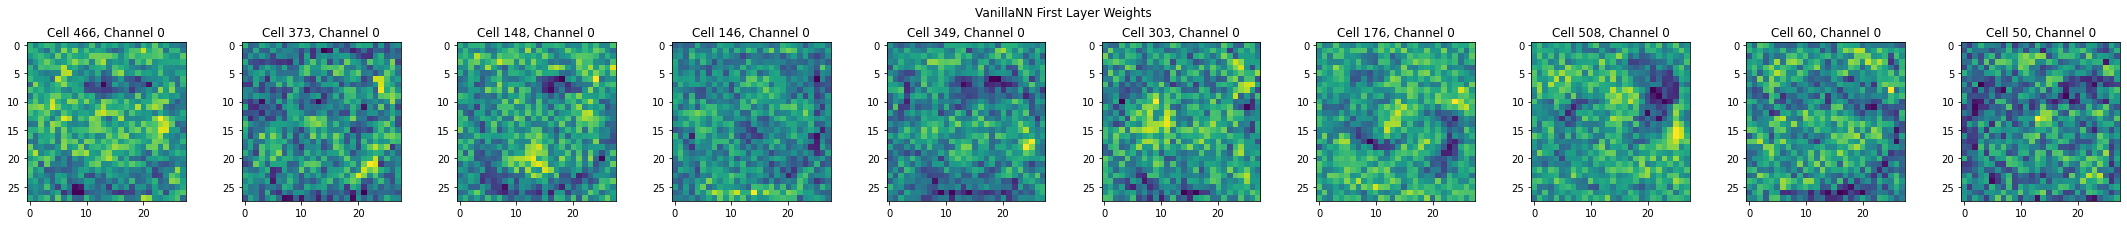

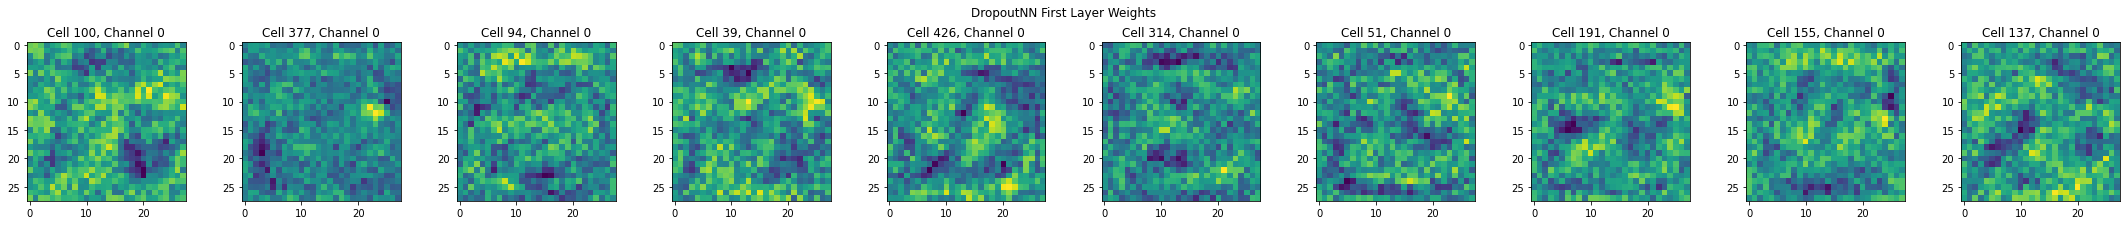

In [25]:
%matplotlib inline

d, h, w = dataset[0][0].shape
plot_first_hidden_layer(vnn, "VanillaNN First Layer Weights", h, w, d)
plot_first_hidden_layer(dnn, "DropoutNN First Layer Weights", h, w, d)

Double click on each row of plots to make them larger!

**TODO: Are there visual differences between the vanilla and dropout model weights? How does dropout cause these differences in the weights?**

*The vanilla weights are much closer to noise, where the dropout weights clearly pick out individual features. This is because the dropout weights can't rely on using multiple units to pick out any given feature, so each unit needs to be able to activate on a feature in its entirety.*

# Optimal Images 

Below, we choose random individual neurons from the 'vanilla' net and the dropout net. For each neuron, we train an optimal image to maximally activate its neuron, then display the optimal image.

In [26]:
def generate_optimal_image(
    model: nn.Module,
    run_through_layers: int,
    nodes: int,
    width: int,
    height: int,
    depth: int,
    device,
    learning_rate: int = 5e-4,
    epochs: int = 4500,
    optimize_range: bool = False
) -> np.ndarray:
    # Put model in evaluation mode, we only want to optimize the image...
    model.eval()
    # Create a random image...
    img = torch.randn(1, depth, height, width, device=device, requires_grad=True)
    optimizer = optim.Adam([img], lr=learning_rate)
    loss_func = nn.MSELoss()
    
    print(f"Optimize Values After Layer {model.linear_layer(run_through_layers - 1)}, Node: {nodes}")
    
    for i in range(epochs):
        # Zero gradients...
        if img.grad is not None:
            img.grad.detach_()
            img.grad.zero_()
        model.zero_grad()
        # Run model...
        predicted = model.forward(img, run_through_layers)
        
        mask = np.zeros(predicted.shape[1], bool)
        mask[nodes] = 1
        
        node_score = torch.min(predicted[0, mask])
        not_node_score = torch.max(predicted[0, ~mask])
        
        # Compute loss, backpropigate, and optimize the weights...
        # Our loss: Maximize the range between nodes of interest and other nodes
        loss = -node_score if(not optimize_range) else -node_score + not_node_score
        
        loss.backward()
        optimizer.step()
        
        # All images are made up of channels that range from 0 to 1, so clamp values within that range...
        with torch.no_grad():
            img.clamp_(0, 1)

        if((i % 500 == 0) or (i == (epochs - 1))):
            print(f"Epoch: {i}/{epochs}, Loss: {loss:.02f}")
            
    return img

def random_optimal_images_from(
    model: nn.Module, 
    layer: int, 
    num_samples: int,
    width: int, 
    height: int, 
    depth: int, 
    device,
    *args,
    **kwargs
) -> tuple:
    imgs = []
    samples = np.random.choice(model.linear_layer(layer - 1).weight.shape[0], num_samples, replace=False)
    %matplotlib notebook
    
    for i, sample in enumerate(samples):
        print(f"Working on image {i + 1}/{num_samples}")
        imgs.append(
            generate_optimal_image(model, layer, sample, height, width, depth, device, *args, **kwargs)
        )
    
    fig, axs = plt.subplots(depth, num_samples, squeeze=False)
    fig.set_size_inches(3 * num_samples, 3 * depth)
    fig.suptitle(type(model).__name__)
    
    for img, sample_i, sub_axs in zip(imgs, samples, axs.T):
        for j, ax in enumerate(sub_axs):
            img2 = img.cpu().detach().numpy()[0, j]
            ax.set_title(f"Layer {layer}, Node {sample_i}, Channel {j}")
            m = ax.imshow(img2, cmap="plasma") 
    
    fig.colorbar(m)
    fig.tight_layout()
    fig.show()
    
    return fig, axs, imgs, samples

Working on image 1/10
Optimize Values After Layer Linear(in_features=1024, out_features=10, bias=True), Node: 2
Epoch: 0/4500, Loss: 3.94
Epoch: 500/4500, Loss: -25.20
Epoch: 1000/4500, Loss: -49.19
Epoch: 1500/4500, Loss: -68.80
Epoch: 2000/4500, Loss: -86.07
Epoch: 2500/4500, Loss: -95.92
Epoch: 3000/4500, Loss: -99.57
Epoch: 3500/4500, Loss: -101.06
Epoch: 4000/4500, Loss: -102.17
Epoch: 4499/4500, Loss: -102.95
Working on image 2/10
Optimize Values After Layer Linear(in_features=1024, out_features=10, bias=True), Node: 6
Epoch: 0/4500, Loss: 13.07
Epoch: 500/4500, Loss: -16.41
Epoch: 1000/4500, Loss: -35.30
Epoch: 1500/4500, Loss: -49.14
Epoch: 2000/4500, Loss: -62.49
Epoch: 2500/4500, Loss: -72.07
Epoch: 3000/4500, Loss: -76.82
Epoch: 3500/4500, Loss: -79.15
Epoch: 4000/4500, Loss: -80.46
Epoch: 4499/4500, Loss: -81.14
Working on image 3/10
Optimize Values After Layer Linear(in_features=1024, out_features=10, bias=True), Node: 0
Epoch: 0/4500, Loss: 10.13
Epoch: 500/4500, Loss: -1

<IPython.core.display.Javascript object>


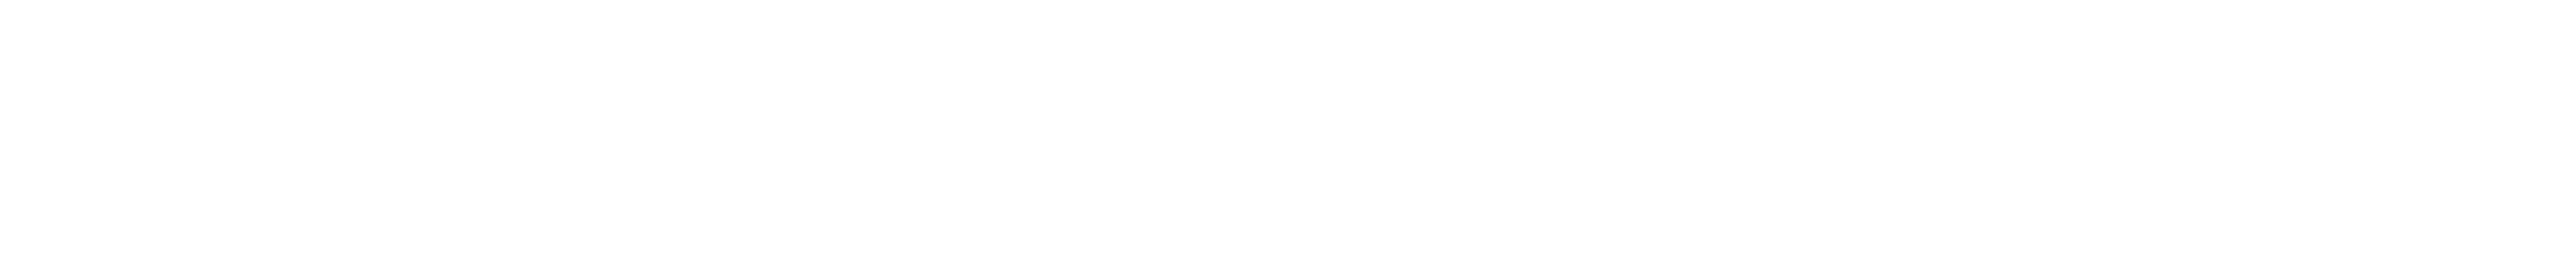

Working on image 1/10
Optimize Values After Layer Linear(in_features=1024, out_features=10, bias=True), Node: 1
Epoch: 0/4500, Loss: 5.51
Epoch: 500/4500, Loss: 2.30
Epoch: 1000/4500, Loss: -1.32
Epoch: 1500/4500, Loss: -8.09
Epoch: 2000/4500, Loss: -17.77
Epoch: 2500/4500, Loss: -27.46
Epoch: 3000/4500, Loss: -34.59
Epoch: 3500/4500, Loss: -38.34
Epoch: 4000/4500, Loss: -40.55
Epoch: 4499/4500, Loss: -41.87
Working on image 2/10
Optimize Values After Layer Linear(in_features=1024, out_features=10, bias=True), Node: 7
Epoch: 0/4500, Loss: 33.46
Epoch: 500/4500, Loss: -14.20
Epoch: 1000/4500, Loss: -49.89
Epoch: 1500/4500, Loss: -81.64
Epoch: 2000/4500, Loss: -101.54
Epoch: 2500/4500, Loss: -107.14
Epoch: 3000/4500, Loss: -109.06
Epoch: 3500/4500, Loss: -109.93
Epoch: 4000/4500, Loss: -110.31
Epoch: 4499/4500, Loss: -110.52
Working on image 3/10
Optimize Values After Layer Linear(in_features=1024, out_features=10, bias=True), Node: 4
Epoch: 0/4500, Loss: 12.29
Epoch: 500/4500, Loss: -0.

<IPython.core.display.Javascript object>


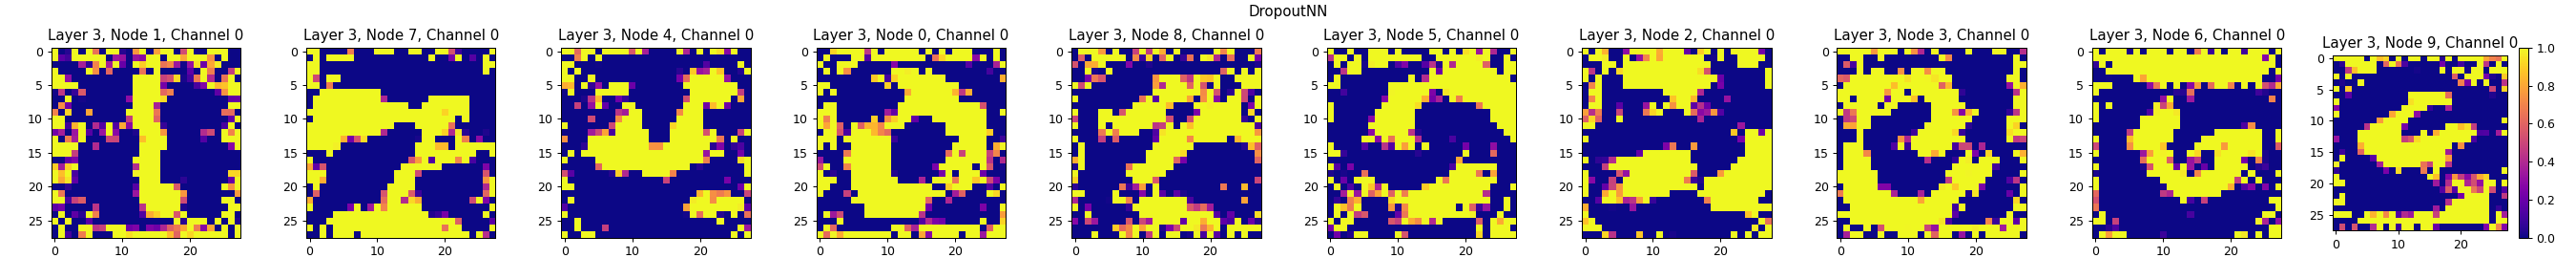

In [35]:
%matplotlib inline
vanilla_res = random_optimal_images_from(vnn, 3, 10, h, w, d, device, optimize_range=True)[0]
dropout_res = random_optimal_images_from(dnn, 3, 10, h, w, d, device, optimize_range=True)[0]

<IPython.core.display.Javascript object>


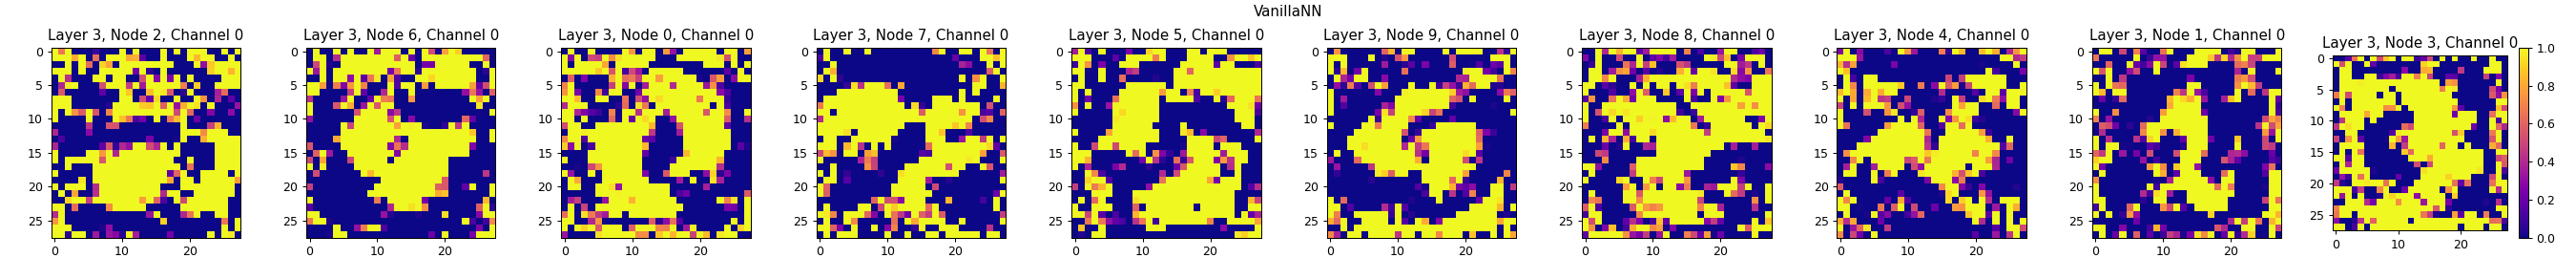

In [36]:
%matplotlib inline
vanilla_res

<IPython.core.display.Javascript object>


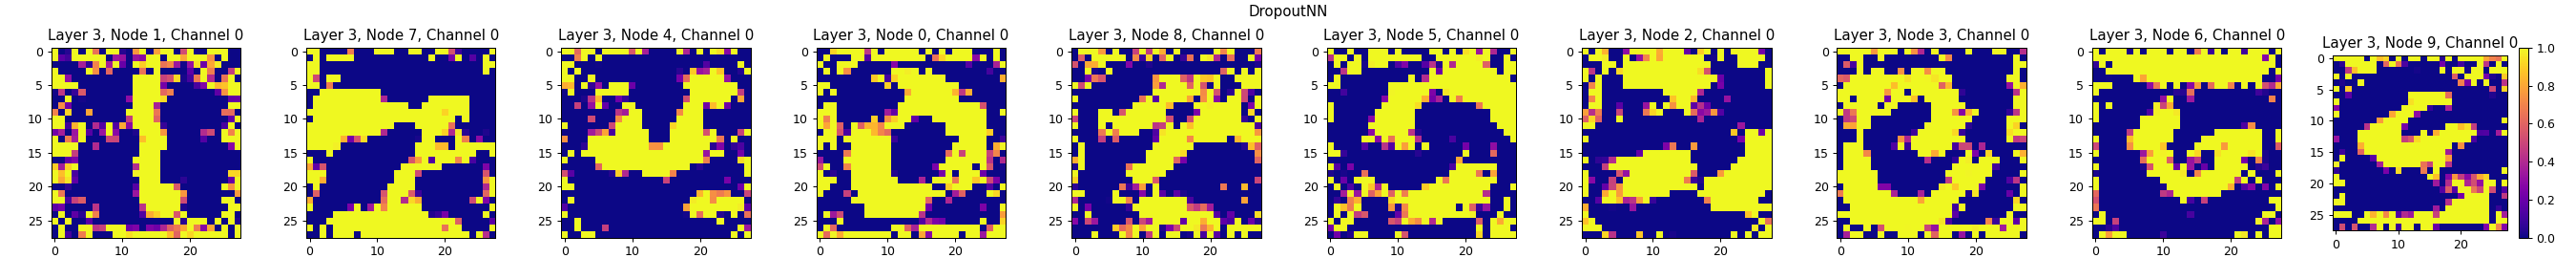

In [37]:
%matplotlib inline
dropout_res

**TODO: Are there any differences between the 'vanilla' net optimal images and the dropout net optimal images? If so, what do you think led to these differences?**

*I'm actually surprised by how clean the vanilla outputs are, even though they are still noisier than the dropout results. As we saw with the weights on the input layer, I think the noise on the vanilla output is again coming from each unit's ability to "rely" on other units in the network to compensate in identifying a specific feature. The dropout units have learned to be self-reliant, so they will be optimally activated by a "cleaner" image with  larger areas of activation.*

**TODO: The above function allows you to randomly sample nodes from any layer of the network for generating optimal images (Currently set to layer 4, the final layer output). What results do you get when changing the layer optimal images are being generated for? How do the Vanilla NN and Dropout NN results compare and differ?**

*I can't really tell the difference between the outputs of the inner layers--they are pretty noisy for both the vanilla and the dropout models. I think this makes sense in comparison to the output, since the inner layers won't ever be expected to map back to a visual space. In other words, the last layer is expected to map to something analogous to the input, while the inner layers are much more functional and abstracted from any sort of visualization.* 